In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np
from census import Census # This is new...

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

In [6]:
dfenduse = pd.read_excel("./data/HS2012-17-BEC5 -- 08 Nov 2018.xlsx", sheet_name="HS17BEC5", usecols = ["HS6", "BEC5EndUse"], dtype=str)

dfenduse["BEC5EndUse"].unique()

# Define a dictionary for replacements
replacement_dict = {
    "INT/CONS": "INT",
    'CONS/INT': "CONS",
    'CAP/INT': "CAP",
    "INT/CAP": "INT",
    'CAP/CONS': "CAP",
    'CONS/CAP': "CONS",
    np.nan: "OTHER",
}

dfenduse["BEC5EndUse"] = dfenduse["BEC5EndUse"].replace(replacement_dict)

dfenduse["BEC5EndUse"].unique()

dfenduse.to_parquet("hs6-enduse.parquet", index=False)

In [5]:
dfenduse[dfenduse["BEC5EndUse"] == "CONS"]

,HS6,BEC5EndUse
35,020120,CONS
36,020130,CONS
38,020220,CONS
39,020230,CONS
41,020312,CONS
...,...,...
5382,970200,CONS
5383,970300,CONS
5384,970400,CONS
5385,970500,CONS


In [32]:
country_list = pd.read_csv('./data/top_50_non_eu.csv', dtype={'CTY_CODE': str})

country_list.loc[len(country_list)] = ["EUROPEAN UNION", 0 , "0003"]

In [33]:
country_list.head()

,CTY_NAME,total_imports,CTY_CODE
0,CHINA,5.728638e+12,5700
1,MEXICO,4.385957e+12,2010
2,CANADA,4.161438e+12,1220
3,JAPAN,1.701399e+12,5880
4,"KOREA, SOUTH",1.045098e+12,5800


array(['CAP', 'INT', 'CONS', 'OTHER'], dtype=object)

In [110]:
def download_imports(cntry_code, year):

    my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

    hs = 'HS6'

    my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

    end_use = "hs?get=CTY_NAME,CON_VAL_YR,CAL_DUT_YR,I_COMMODITY,I_COMMODITY_SDESC"

    surl = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 

    surl  = surl + my_key + "&time=" + year + "-12" + "&COMM_LVL=" + hs 

    url = surl + "&CTY_CODE=" + cntry_code

    r = requests.get(url) 
        
    print(cntry_code, r)
        
    df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
        # Note that the first entry is the labels

    df.columns = r.json()[0]

        #######################################################################

    df.time = pd.to_datetime(df.time, format="%Y-%m")

    df["imports"] = df["CON_VAL_YR"].astype(float)

    df["duty"] = df["CAL_DUT_YR"].astype(float)

    df["2024_tariff"] = df["duty"] / df["imports"]

    df[hs] = df["I_COMMODITY"].astype(str)

    return df


In [111]:
def get_good_composition(country_code, country_name, year, dfenduse=dfenduse):

    df = download_imports(country_code, year)

    merged_df = pd.merge(
        dfenduse, 
        df, 
        on="HS6", 
        how="outer",  # Use 'outer' to include all rows and identify mismatches
        indicator=True  # Adds a column '_merge' to indicate the source of each row
        )
    
    grp = merged_df.groupby(["BEC5EndUse"])

    share_df = grp.agg({"imports": "sum", "duty": "sum"})

    share_df.reset_index(inplace=True)

    name_mapping = {
    "CAP": "Capital Goods",
    "CONS": "Consumption Goods",
    "INT": "Intermediate Inputs",
    "OTHER": "Other",
    }   

    # Replace names in the column using the dictionary
    share_df["BEC5EndUse"] = share_df["BEC5EndUse"].replace(name_mapping)

    share_df.rename(columns = {"BEC5EndUse": "Good Type"}, inplace = True)

    share_df["share of imports"] = 100*share_df["imports"] / share_df["imports"].sum()

    share_df["CTY_NAME"] = country_name

    share_df.set_index(["CTY_NAME", "Good Type"], inplace=True)

    return share_df

In [119]:
year = "2013"

df = pd.DataFrame()

for index, row in country_list.iterrows():

    out = get_good_composition(row['CTY_CODE'], row['CTY_NAME'], year)

    df = pd.concat([df, out])

# Reset index to work with the data
df_reset = df.reset_index()

# Calculate each country's share within each good type
# This gives: (country's imports in good type X) / (all countries' imports in good type X) * 100
df_reset['share of total_type'] = (
    df_reset['imports'] / 
    df_reset.groupby('Good Type')['imports'].transform('sum')
) * 100

# Set index back
df_reset.set_index(['CTY_NAME', 'Good Type'], inplace=True)

outfile = "./data/" + year + "-trade-composition.parquet"

pq.write_table(pa.Table.from_pandas(df_reset), outfile)

5700 <Response [200]>
2010 <Response [200]>
1220 <Response [200]>
5880 <Response [200]>
5800 <Response [200]>
5520 <Response [200]>
5830 <Response [200]>
5330 <Response [200]>
4120 <Response [200]>
4419 <Response [200]>
5570 <Response [200]>
5490 <Response [200]>
3510 <Response [200]>
5590 <Response [200]>
5600 <Response [200]>
5081 <Response [200]>
5170 <Response [200]>
4621 <Response [200]>
3010 <Response [200]>
6021 <Response [200]>
5650 <Response [200]>
3370 <Response [200]>
4890 <Response [200]>
7910 <Response [200]>
3070 <Response [200]>
5050 <Response [200]>
3310 <Response [200]>
2230 <Response [200]>
3330 <Response [200]>
5380 <Response [200]>
5550 <Response [200]>
5820 <Response [200]>
4039 <Response [200]>
2470 <Response [200]>
3570 <Response [200]>
7530 <Response [200]>
2150 <Response [200]>
6141 <Response [200]>
4359 <Response [200]>
5200 <Response [200]>
2050 <Response [200]>
5350 <Response [200]>
2740 <Response [200]>
2190 <Response [200]>
5130 <Response [200]>
7210 <Resp

In [120]:
# Example: China's share within each good type
china_shares = df_reset.loc["CHINA", 'share of total_type']
print("China's share of each good type:")
print(china_shares)


China's share of each good type:
Good Type
Capital Goods          31.294255
Consumption Goods      26.364886
Intermediate Inputs    10.921289
Other                   3.226822
Name: share of total_type, dtype: float64


In [18]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

hs = 'HS6'

my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

end_use = "hs?get=CTY_NAME,CON_VAL_MO,CAL_DUT_MO,I_COMMODITY,I_COMMODITY_SDESC"

surl = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 

surl  = surl + my_key + "&time=" + "2025-07" + "&COMM_LVL=" + hs 

url = surl + "&CTY_CODE=" + '-'

r = requests.get(url) 
    
print(r)
    
df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
    # Note that the first entry is the labels

df.columns = r.json()[0]

    #######################################################################

df.time = pd.to_datetime(df.time, format="%Y-%m")

df["imports"] = df["CON_VAL_MO"].astype(float)

df["duty"] = df["CAL_DUT_MO"].astype(float)

df["2025_tariff"] = df["duty"] / df["imports"]

df[hs] = df["I_COMMODITY"].astype(str)


<Response [200]>


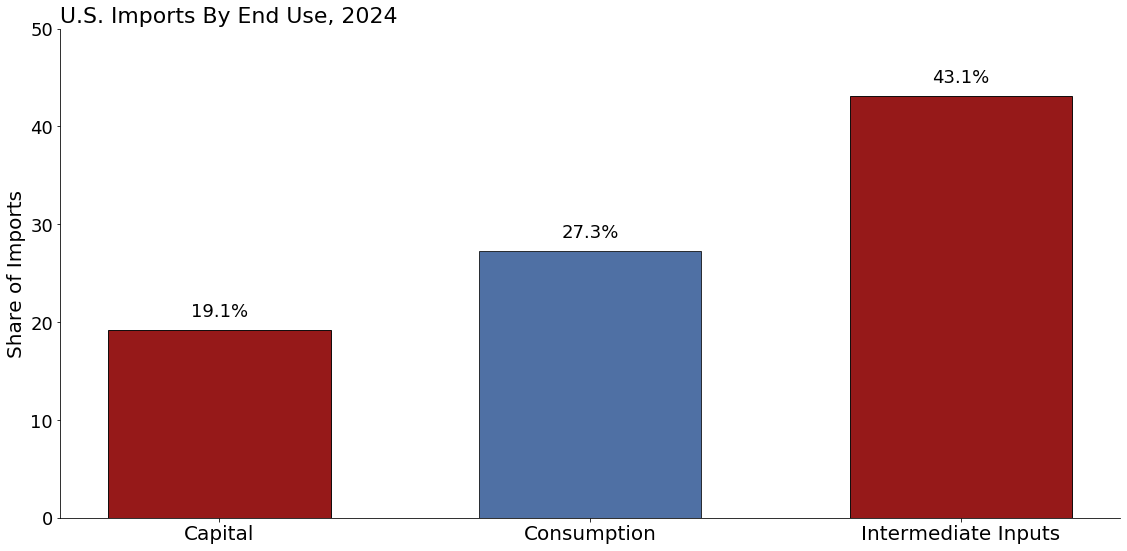

In [20]:
fig, ax = plt.subplots(figsize=(19, 9))

# Define colors and alpha values
colors = ['darkred'] * len(share_df.iloc[:-1])  # Default all bars to dark red
alphas = [0.9] * len(share_df.iloc[:-1])       # Default all bars to alpha 0.9

# Modify the middle bar
middle_index = len(share_df.iloc[:-1]) // 2
colors[middle_index] = tuple(np.array([20, 64, 134]) / 255)  # Blue color
alphas[middle_index] = 0.75                                   # Alpha 0.5

# Create bars and set individual colors and alpha values
bars = ax.bar(
    share_df.iloc[:-1].BEC5EndUse,
    100. * share_df.iloc[:-1].share,
    color=colors,
    edgecolor="black",
    width=0.60
)

# Set alpha for each bar individually
for bar, alpha in zip(bars, alphas):
    bar.set_alpha(alpha)

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()  # Get the height of the bar
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        height + 1,  # Y-coordinate (slightly above the bar)
        f'{height:.1f}%',  # Format the value (e.g., 1 decimal place with a % sign)
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=18  # Font size
    )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.tick_params(axis='x', labelsize=20)  # Change font size of x-axis tick labels
ax.tick_params(axis='y', labelsize=18)  # Change font size of y-axis tick labels

ax.set_ylim(0, 50)

ax.set_title("U.S. Imports By End Use, 2024", fontsize=22, loc="left")
ax.set_ylabel('Share of Imports', fontsize=20)

plt.savefig("./figures/imports-end-use.png", bbox_inches="tight", dip=3600)
plt.savefig("./figures/imports-end-use.pdf", bbox_inches="tight", dip=3600)

plt.show()